# CNN İLE TİME SERİES PREDİCTİON

# You are expected to forecast daily cash transactions for an ATM. The training data is provided as a .csv file. It includes 3 columns: CashIn, CashOut, and Date. CashIn column contains the total deposit amount of the ATM for the given date. CashOut column contains the withdrawal values of given date on ATM. (i.e. CashIn: Toplam yatırılan para miktarı, CashOut: Toplam çekilen para miktarı).Using the data you have been provided, you are expected to forecast the CashIn and CashOut values between 2019-04-01 and 2019-04-30.

In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np 
import os 
import pandas as pd 
import sklearn
from keras import optimizers
import tensorflow as tf
import keras
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten,Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Dense ,BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn import metrics
import seaborn as sns
import math
import time
from sklearn.impute import KNNImputer

import datetime 
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings("ignore") 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

np.random.seed(1234453)  
PYTHONHASHSEED = 0

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/arutedata/ds_exercise_data.csv


In [3]:
df = pd.read_csv('/kaggle/input/arutedata/ds_exercise_data.csv')

In [4]:
df.head(10)

,Date,CashIn,CashOut
0,1/1/2016,NaN,6500.0
1,1/2/2016,NaN,23110.0
2,1/3/2016,NaN,7070.0
3,1/4/2016,NaN,18520.0
4,1/5/2016,20840.0,22200.0
5,1/6/2016,28460.0,18810.0
6,1/7/2016,19250.0,23210.0
7,1/8/2016,49770.0,4350.0
8,1/9/2016,NaN,NaN
9,1/10/2016,19260.0,760.0


In [5]:
df.shape

(1186, 3)

In [6]:
df.drop('CashOut',inplace = True,axis = 1)
#Bu çalışmada sadece CashIn'i kullanacağım.
#Bir sonraki notebook'ta CashOut ile lstm modeli kuracağım.

In [7]:
df['CashIn'].fillna(df['CashIn'].median(),inplace=True)

**Datamızdaki Nan değerleri modele yararı olacağını düşündüğüm için kolonumuzdaki median değerler ile impute edeceğim.**

In [8]:
df.describe()

,CashIn
count,1186.000000
mean,37059.620573
std,19660.819968
min,100.000000
25%,23320.000000
50%,34980.000000
75%,48975.000000
max,121300.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1186 non-null   object 
 1   CashIn  1186 non-null   float64
dtypes: float64(1), object(1)
memory usage: 18.7+ KB


<Figure size 2160x720 with 0 Axes>

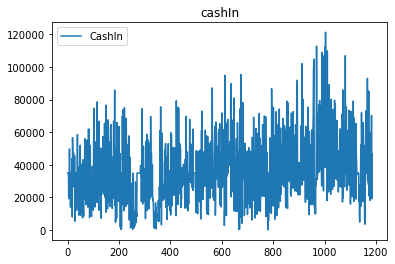

In [10]:
plt.figure(figsize=(30,10))
df.plot(title='cashIn')
plt.show()

# Outliers

<AxesSubplot:ylabel='CashIn'>

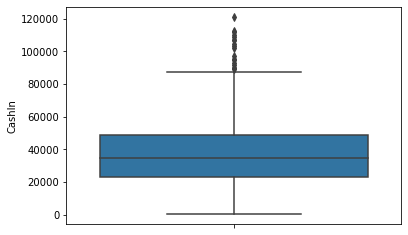

In [11]:
sns.boxplot(y=df.CashIn, data=df)

****Şekilden de görüldüğü üzere 90.000 üzerinde outlier değerlerim var.Bu değerler model performansını çok kötü etkileyecekleri için kesinlikle drop edilmeliler.

In [12]:
df = df.drop(df[df['CashIn'] > 87000].index)

# Preprocessing
**Feature Engineering**

In [13]:
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y") 

In [14]:
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['week_of_year'] = df['Date'].dt.weekofyear
df['quarter'] = df['Date'].dt.quarter
df['month_start'] = np.where(df['Date'].dt.is_month_start,1,0)
df['month_end'] = np.where(df['Date'].dt.is_month_end,1,0)
df['quarter_start'] = np.where(df['Date'].dt.is_quarter_start,1,0)
df['quarter_start'] = np.where(df['Date'].dt.is_quarter_start,1,0)
df['year_start'] = np.where(df['Date'].dt.is_year_start,1,0)
df['year_start'] = np.where(df['Date'].dt.is_year_start,1,0)
df['day_of_week'] = df['Date'].dt.day_name()
df['weekend'] = np.where((df['day_of_week'] == 'Saturday') | (df['day_of_week'] == 'Sunday'),1,0)

In [15]:
df.reset_index(drop=True,inplace=True)
df.set_index('Date',inplace = True)

In [16]:
df['weekly_total'] = df.CashIn.resample('W').sum()
df['montly_total'] = df.CashIn.resample('M').sum()
df['quarterly_total'] = df.CashIn.resample('Q').sum()
df['yearly_total'] = df.CashIn.resample('Y').sum()
df['weekly_total'].fillna(method="backfill",inplace = True)
df['montly_total'].fillna(method="backfill",inplace = True)
df['quarterly_total'].fillna(method="backfill",inplace = True)
df['yearly_total'].fillna(method="backfill",inplace = True)

**Datamı görüldüğü üzere resample ediyorum.Ondan sonra backfill yöntemi ile Nan değerleri resample mantığına uygun şekilde impute ediyorum.**

##############feature kısmında df.diff() kullanılabiliyormuş.

In [17]:
window_sizes = [7,15,30]
for window in window_sizes:
    df["rolling_mean_" + str(window)] = df['CashIn'].rolling(window=window).mean()
    df["rolling_std_" + str(window)] = df['CashIn'].rolling(window=window).std()
    df["rolling_q25_"+ str(window)] = df['CashIn'].rolling(window=window).quantile(0.25)
    df["rolling_q75_"+ str(window)] = df['CashIn'].rolling(window=window).quantile(0.75)
    df["rolling_q90_"+ str(window)] = df['CashIn'].rolling(window=window).quantile(0.90)
    df["rolling_min_"+ str(window)] = df['CashIn'].rolling(window=window).min()
    df["rolling_max_"+ str(window)] = df['CashIn'].rolling(window=window).max()

**Burada aslında zaman serilerin çok kullanılan özellikleri datama ekliyorum.7,15 ve 30 gün olacak şekilde CashIn kolonuma rolling uyguluyorum.Bu özellikler bana oluşan trendler hakkında bilgi verecek ve model performansımı iyi yönde etkileyecektir.**

In [18]:
df.head()

,CashIn,month,year,week_of_year,quarter,month_start,month_end,quarter_start,year_start,day_of_week,weekend,weekly_total,montly_total,quarterly_total,yearly_total,rolling_mean_7,rolling_std_7,rolling_q25_7,rolling_q75_7,rolling_q90_7,rolling_min_7,rolling_max_7,rolling_mean_15,rolling_std_15,rolling_q25_15,rolling_q75_15,rolling_q90_15,rolling_min_15,rolling_max_15,rolling_mean_30,rolling_std_30,rolling_q25_30,rolling_q75_30,rolling_q90_30,rolling_min_30,rolling_max_30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,34980.0,1,2016,53,1,1,0,1,1,Friday,0,104940.0,940170.0,2809450.0,11013490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,34980.0,1,2016,53,1,0,0,0,0,Saturday,1,104940.0,940170.0,2809450.0,11013490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,34980.0,1,2016,53,1,0,0,0,0,Sunday,1,104940.0,940170.0,2809450.0,11013490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,34980.0,1,2016,1,1,0,0,0,0,Monday,0,207540.0,940170.0,2809450.0,11013490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,20840.0,1,2016,1,1,0,0,0,0,Tuesday,0,207540.0,940170.0,2809450.0,11013490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df['year'] = df['year'].apply(str)

**Yıl kolonum sayı olarak düşünülebilir fakat bu kategorize edilmelidir.İleride one hot encode edeceğim.**

In [20]:
df['target'] = df.CashIn.shift(-30,axis = 0)

**Target olarak cashın kolonumu 30 gün shift ediyorum.Buradaki amacım özetle şu şekilde,modeli kurarken normalde gelecek hakkında bir fikre sahip değiliz ama geçmişteki gelecek hakkında bilgi sahibiyiz.Mesela datamızda hem 2017 ocak ayının hem de 2017 şubat ayının değerleri var.Burada şubat ayını -30 gün shiftliyorum ve datasette ocak ayının karşılığındaki target rowlarına şubat ayının değerlerini yerleştirmiş oluyorum.**

In [21]:
categorical_columns = ['year', 'day_of_week']

**Bu kısımda kategorik değişkenlerimi işaretliyorum.Bunları one hot encode edeceğim.Nümerik kolonlarımı scale edeceğim.**

In [22]:
feature_scale = [feature for feature in df.columns if feature not in categorical_columns]

scaler = StandardScaler()
scaler.fit(df[feature_scale])

scaled_data = pd.concat([df[categorical_columns].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(df[feature_scale]), columns=feature_scale)],axis=1)

**Nümerik kolonlarım standard scale kullanılarak scale edildi.**

In [23]:
df = pd.get_dummies(scaled_data, columns = ['day_of_week','month','year','week_of_year','quarter'], drop_first=True)

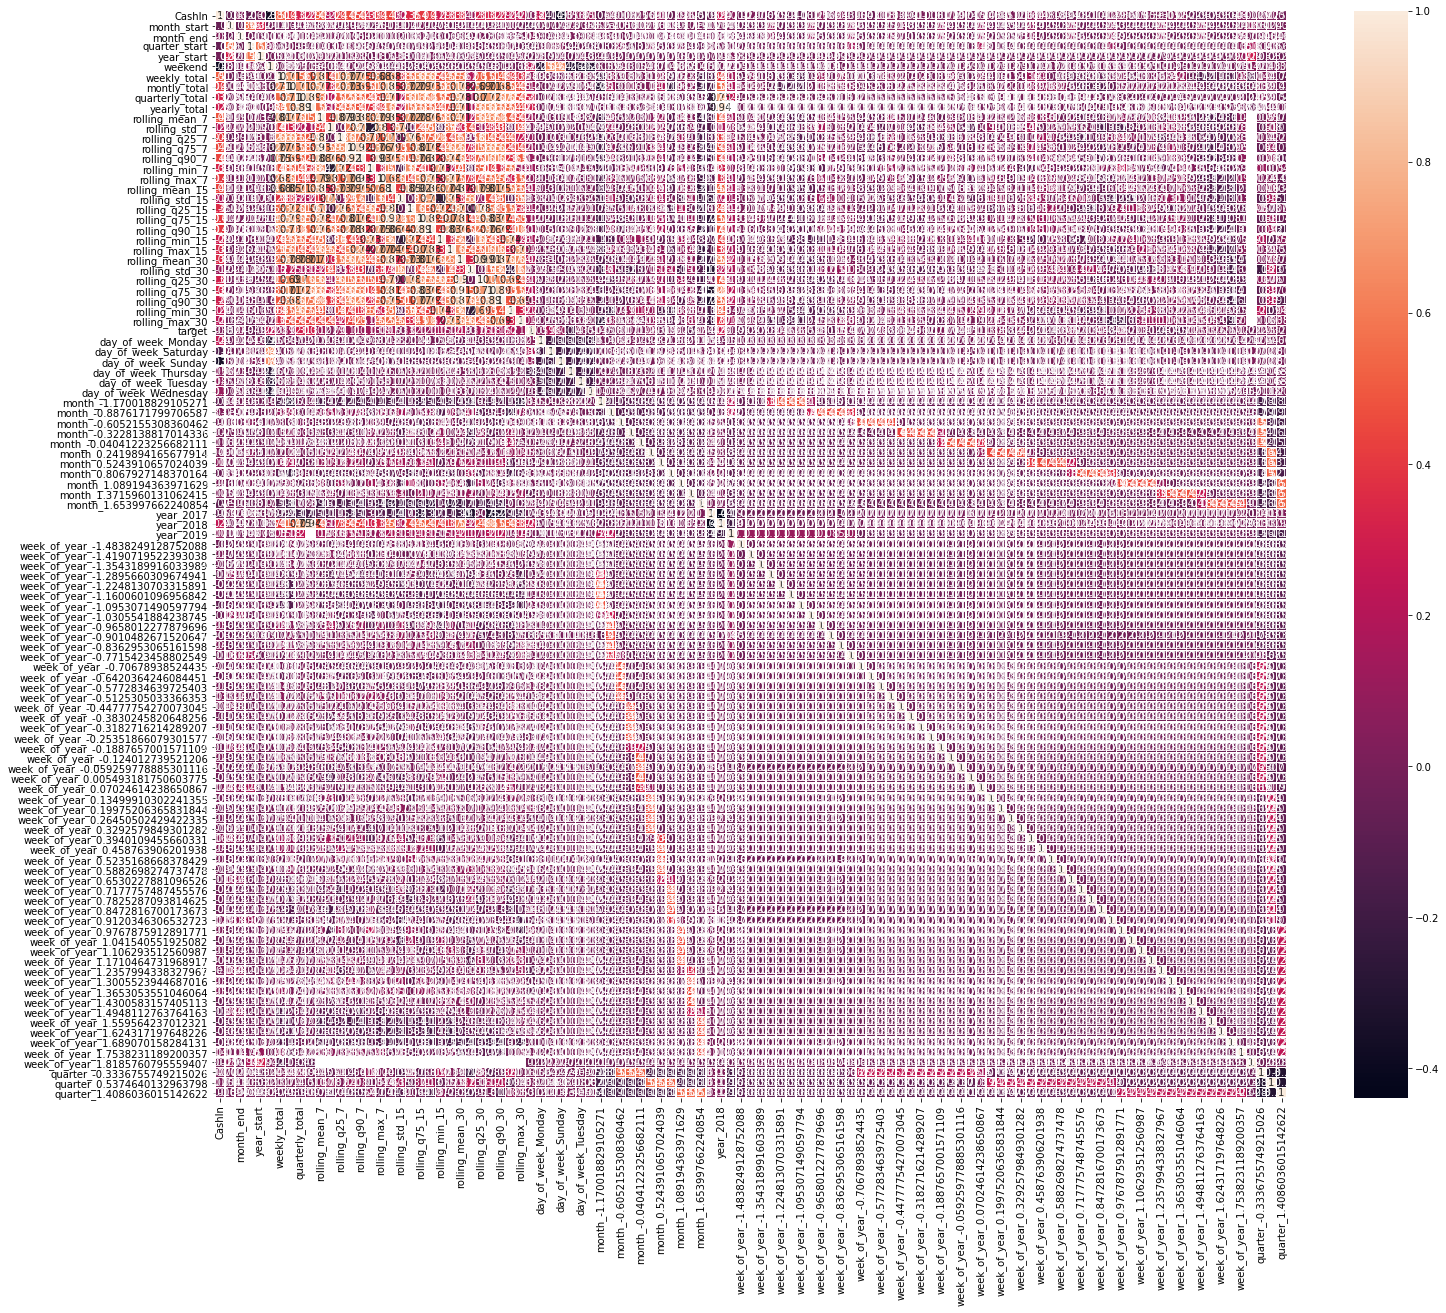

In [24]:
plt.subplots(figsize=(24,20))
sns.heatmap(df.corr(), annot=True, linewidths=.5);

In [25]:
df.head()

,CashIn,month_start,month_end,quarter_start,year_start,weekend,weekly_total,montly_total,quarterly_total,yearly_total,rolling_mean_7,rolling_std_7,rolling_q25_7,rolling_q75_7,rolling_q90_7,rolling_min_7,rolling_max_7,rolling_mean_15,rolling_std_15,rolling_q25_15,rolling_q75_15,rolling_q90_15,rolling_min_15,rolling_max_15,rolling_mean_30,rolling_std_30,rolling_q25_30,rolling_q75_30,rolling_q90_30,rolling_min_30,rolling_max_30,target,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,month_-1.170018829105271,month_-0.8876171799706587,month_-0.6052155308360462,month_-0.3228138817014336,month_-0.04041223256682111,month_0.2419894165677914,month_0.5243910657024039,month_0.8067927148370164,month_1.089194363971629,month_1.3715960131062415,month_1.653997662240854,year_2017,year_2018,year_2019,week_of_year_-1.4838249128752088,week_of_year_-1.4190719522393038,week_of_year_-1.3543189916033989,week_of_year_-1.2895660309674941,week_of_year_-1.2248130703315891,week_of_year_-1.1600601096956842,week_of_year_-1.0953071490597794,week_of_year_-1.0305541884238745,week_of_year_-0.9658012277879696,week_of_year_-0.9010482671520647,week_of_year_-0.8362953065161598,week_of_year_-0.7715423458802549,week_of_year_-0.70678938524435,week_of_year_-0.6420364246084451,week_of_year_-0.5772834639725403,week_of_year_-0.5125305033366353,week_of_year_-0.44777754270073045,week_of_year_-0.3830245820648256,week_of_year_-0.3182716214289207,week_of_year_-0.25351866079301577,week_of_year_-0.1887657001571109,week_of_year_-0.124012739521206,week_of_year_-0.059259778885301116,week_of_year_0.005493181750603775,week_of_year_0.07024614238650867,week_of_year_0.13499910302241355,week_of_year_0.19975206365831844,week_of_year_0.26450502429422335,week_of_year_0.3292579849301282,week_of_year_0.3940109455660331,week_of_year_0.458763906201938,week_of_year_0.5235168668378429,week_of_year_0.5882698274737478,week_of_year_0.6530227881096526,week_of_year_0.7177757487455576,week_of_year_0.7825287093814625,week_of_year_0.8472816700173673,week_of_year_0.9120346306532723,week_of_year_0.9767875912891771,week_of_year_1.041540551925082,week_of_year_1.106293512560987,week_of_year_1.1710464731968917,week_of_year_1.2357994338327967,week_of_year_1.3005523944687016,week_of_year_1.3653053551046064,week_of_year_1.4300583157405113,week_of_year_1.4948112763764163,week_of_year_1.559564237012321,week_of_year_1.624317197648226,week_of_year_1.689070158284131,week_of_year_1.7538231189200357,week_of_year_1.8185760795559407,quarter_-0.3336755749215026,quarter_0.5374640132963798,quarter_1.4086036015142622
0,-0.057811,5.450736,-0.185942,9.810708,17.051393,-0.64119,-2.181023,-0.643985,-0.914357,-1.078566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.143039,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,-0.057811,-0.183461,-0.185942,-0.101929,-0.058646,1.55960,-2.181023,-0.643985,-0.914357,-1.078566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.046823,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,-0.057811,-0.183461,-0.185942,-0.101929,-0.058646,1.55960,-2.181023,-0.643985,-0.914357,-1.078566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.065066,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,-0.057811,-0.183461,-0.185942,-0.101929,-0.058646,-0.64119,-0.618291,-0.643985,-0.914357,-1.078566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.065066,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

**Rollemenin sonucunda oluşan kolonlarda bazı nan değerler görüyorum.Bu boşlukları doldurmada bu sefer KNNimputer kullanacağım.Bu imputer bana eksik olan rowlarıma benzer rowları bulup onları yerleştirecek.Datamda bu değerleri Nan olarak bıraktığım zaman Cnn modelim bana hata döndürecektir.Bu değerlerin yerine 0 yazmak modelimin performansını olumsuz yönde etkileyecektir.**

In [26]:
imputer = KNNImputer(n_neighbors = 5)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

In [27]:
features = df.drop(columns = ['target']).columns

X = df[features]
y = df.target

In [28]:
train_df = X[:900]
test_df = X[900:]
train_y = y[:900]
test_y = y[900:]

In [29]:
train_df_series = train_df.values.reshape((train_df.shape[0], train_df.shape[1], 1))
test_df_series = test_df.values.reshape((test_df.shape[0], test_df.shape[1], 1))
print('Train set shape', train_df_series.shape)
print('Validation set shape', test_df_series.shape)

Train set shape (900, 106, 1)
Validation set shape (267, 106, 1)


In [30]:
def model_cnn():
    model = Sequential([
        Conv1D(filters=106, kernel_size=3, activation = tf.keras.layers.LeakyReLU(0.4),input_shape = (106,1)),
        MaxPooling1D(2),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=3,activation = tf.keras.layers.LeakyReLU(0.1)),
        MaxPooling1D(2),
        Dropout(0.6),
        Conv1D(filters=32, kernel_size=3, activation = tf.keras.layers.LeakyReLU(0.1)),
        MaxPooling1D(2),
        Dropout(0.6),
        Flatten(),
        Dense(16, activation = 'relu'),
        Dense(8, activation = 'relu'),
        Dense(1, activation='linear')
    ])
    opt = keras.optimizers.Adam(learning_rate=0.0005)

    model.compile(
        loss='mse',
        optimizer=opt,
        metrics='mse'
    )
    return model

model = model_cnn()
model.summary()
model.save_weights('/tmp/model_weights_init.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 104, 106)          424       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 52, 106)           0         
_________________________________________________________________
dropout (Dropout)            (None, 52, 106)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 64)            20416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 23, 32)            6

In [31]:
history = model.fit(train_df_series, train_y, validation_data = (test_df_series, test_y), epochs = 100,batch_size = 64, verbose = 1)   

Epoch 1/100
15/15 [==============================] - 2s 65ms/step - loss: 0.9020 - mse: 0.9020 - val_loss: 1.1226 - val_mse: 1.1226
Epoch 2/100
15/15 [==============================] - 0s 26ms/step - loss: 0.8930 - mse: 0.8930 - val_loss: 1.1296 - val_mse: 1.1296
Epoch 3/100
15/15 [==============================] - 0s 26ms/step - loss: 0.8987 - mse: 0.8987 - val_loss: 1.1368 - val_mse: 1.1368
Epoch 4/100
15/15 [==============================] - 0s 27ms/step - loss: 0.9588 - mse: 0.9588 - val_loss: 1.1296 - val_mse: 1.1296
Epoch 5/100
15/15 [==============================] - 0s 26ms/step - loss: 0.9991 - mse: 0.9991 - val_loss: 1.1305 - val_mse: 1.1305
Epoch 6/100
15/15 [==============================] - 0s 25ms/step - loss: 0.9685 - mse: 0.9685 - val_loss: 1.1319 - val_mse: 1.1319
Epoch 7/100
15/15 [==============================] - 0s 27ms/step - loss: 0.9040 - mse: 0.9040 - val_loss: 1.1287 - val_mse: 1.1287
Epoch 8/100
15/15 [==============================] - 0s 27ms/step - loss: 0.

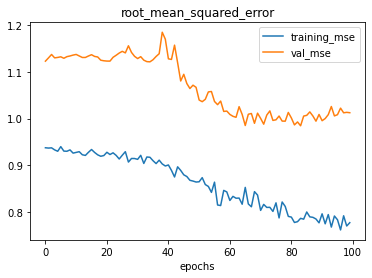

In [32]:
plt.figure(0)
plt.plot(history.history['mse'], label='training_mse')
plt.plot(history.history['val_mse'], label='val_mse')
plt.title('root_mean_squared_error')
plt.xlabel('epochs')
plt.legend()
plt.show()